In [25]:
import sys, os
from scipy.spatial.transform import Rotation as R
from dust3r.inference import inference, load_model
from dust3r.image_pairs import make_pairs
from dust3r.utils.image import load_images, rgb
from dust3r.utils.device import to_numpy
from dust3r.viz import add_scene_cam, CAM_COLORS, OPENGL, pts3d_to_trimesh, cat_meshes
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

import matplotlib.pyplot as plt
from dust3r.utils.geometry import find_reciprocal_matches, xy_grid

import cv2, torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go

In [2]:
def get_file_paths(folder_path):
    file_paths = []  # List to store file paths
    # Walk through all files and directories in the specified folder
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)  # Create full file path
            file_paths.append(file_path)  # Add file path to list
    # Sort the list based on filenames
    file_paths.sort(key=lambda path: os.path.basename(path))
    return file_paths

# imput as a list of [row, pitch, yaw]
def euler_to_rotation_matrix(roll, pitch, yaw):
    """
    Convert euler angles (roll, pitch, yaw) to a rotation matrix.
    """
    R_x = torch.tensor([[1, 0, 0],
                        [0, torch.cos(roll), -torch.sin(roll)],
                        [0, torch.sin(roll), torch.cos(roll)]])
    
    R_y = torch.tensor([[torch.cos(pitch), 0, torch.sin(pitch)],
                        [0, 1, 0],
                        [-torch.sin(pitch), 0, torch.cos(pitch)]])
    
    R_z = torch.tensor([[torch.cos(yaw), -torch.sin(yaw), 0],
                        [torch.sin(yaw), torch.cos(yaw), 0],
                        [0, 0, 1]])
    
    R = torch.matmul(R_z, torch.matmul(R_y, R_x))
    return R
    
def pose_to_transform(batch):
    """
    Construct a batch of transformation matrices from a batch of roll, pitch, yaw, x, y, z.
    The input batch should have the shape (n, 6), where each row is (roll, pitch, yaw, x, y, z).
    The output will have the shape (n, 4, 4), representing the transformation matrices.
    """
    n = batch.size(0)
    transformation_matrices = torch.zeros((n, 4, 4))
    
    for i in range(n):
        roll, pitch, yaw, x, y, z = batch[i]
        rotation_matrix = euler_to_rotation_matrix(roll, pitch, yaw)
        transformation_matrix = torch.eye(4)
        transformation_matrix[:3, :3] = rotation_matrix
        transformation_matrix[:3, 3] = torch.tensor([x, y, z])
        transformation_matrices[i] = transformation_matrix
    
    return transformation_matrices

def rotation_matrix_difference(R1, R2):
    # Compute the difference between the two rotation matrices
    diff = np.dot(R1.T, R2) - np.eye(3)

    # Calculate the Frobenius norm of the difference
    frobenius_norm = np.linalg.norm(diff, 'fro')

    return frobenius_norm

def euler_angle_error(euler_angles1, euler_angles2):
    # Ensure both inputs are numpy arrays
    euler_angles1 = np.array(euler_angles1)
    euler_angles2 = np.array(euler_angles2)

    # Compute the absolute difference for each angle component
    absolute_difference = np.abs(euler_angles1 - euler_angles2)

    # Calculate the Euclidean norm of the absolute difference
    error_norm = np.linalg.norm(absolute_difference)

    return error_norm

    return absolute_difference

def residual_error(T_R, A, B, Z):
    """
    Compute the residual error for the rotation matrix R.
    
    Parameters:
    R (base to world): torch.Tensor
        The estimated rotation matrix of shape (3, 3).
    A (world to cam), B (base to gripper): torch.Tensor
        3D rotation tensors of shape (N, 3, 3) representing sequences of 
        transformations A and B respectively.
    Z (gripper to cam): torch.Tensor 3D rotation tensors of shape (N, 3, 3) 
        representing sequences of rotation respectively.
    
    Returns:
    error : float
        The average residual error.
    """
    N = A.shape[0]
    errors = []
    for i in range(N):
        AR = np.matmul(A[i], T_R)
        ZB = np.matmul(Z, B[i])
        
        r1 = R.from_matrix(AR)
        r2 = R.from_matrix(ZB)

        # Convert the rotation to Euler angles (in radians)
        euler_angles_1 = r1.as_euler('xyz', degrees=False)
        euler_angles_2 = r2.as_euler('xyz', degrees=False)
        error = euler_angle_error(euler_angles_1, euler_angles_2)
        #print(error)
        errors.append(error)
    return sum(errors) / N

def extract_positions_directions(transform_matrices):
    positions = transform_matrices[:, :3, 3]
    forward_directions = transform_matrices[:, :3, 2]  # Negate if your camera looks along the -Z axis
    return positions, forward_directions

In [3]:
device="cuda"
model_path = "checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth"
model = load_model(model_path, device)
folder_path = 'n_imgs/'
file_paths = get_file_paths(folder_path)#[:4]
images = load_images(file_paths, size=512)

schedule = 'cosine'
lr = 0.01 # 0.01
niter = 5000
batch_size = 1

pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
output = inference(pairs, model, device, batch_size=batch_size)
scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)



... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_512_dpt.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', patch_embed_cls='PatchEmbedDust3R', img_size=(512, 512), head_type='dpt', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>
>> Loading a list of 10 images
 - adding n_imgs/4bs2sslb3_sa_0.jpg with resolution 640x480 --> 512x384
 - adding n_imgs/4bs2sslb3_sa_1.jpg with resolution 640x480 --> 512x384
 - adding n_imgs/4bs2sslb3_sa_2.jpg with resolution 640x480 --> 512x384
 - adding n_imgs/4bs2sslb3_sa_3.jpg with resolution 640x480 --> 512x384
 - adding n_imgs/4bs2sslb3_sa_4.jpg with resolution 640x480 --> 512x384
 - adding n_imgs/4bs2sslb3_sa_5.jpg with resolution 640x480 --> 512x384
 - adding n_imgs/4bs2sslb3_sa_6.jpg with resolution 640x480 --> 512x384
 - adding n_imgs/4b

100%|███████████████████████████████████████████| 90/90 [00:20<00:00,  4.46it/s]


 init edge (4*,9*) score=51.35506057739258
 init edge (5*,9) score=48.452354431152344
 init edge (5,1*) score=48.1618537902832
 init edge (1,7*) score=45.46013641357422
 init edge (6*,1) score=42.85567092895508
 init edge (1,8*) score=48.16941452026367
 init edge (3*,8) score=44.68656921386719
 init edge (2*,8) score=43.89756393432617
 init edge (0*,8) score=43.10118103027344
 init loss = 0.013169493526220322


100%|███████| 5000/5000 [07:38<00:00, 10.89it/s, lr=1.00099e-06 loss=0.00512631]


In [4]:
imgs = scene.imgs
focals = scene.get_focals()
poses = torch.linalg.inv(scene.get_im_poses())

In [5]:
pts3d = scene.get_pts3d()
confidence_masks = scene.get_masks()

pts_list=[]
for i in range(len(imgs)):
    sel_pts=pts3d[i][confidence_masks[i]]
    pts_list.append(sel_pts)
pts_tor=torch.cat(pts_list).detach().cpu()

In [6]:
positions, directions = extract_positions_directions(poses)
positions=positions.detach().cpu()
directions=directions.detach().cpu()

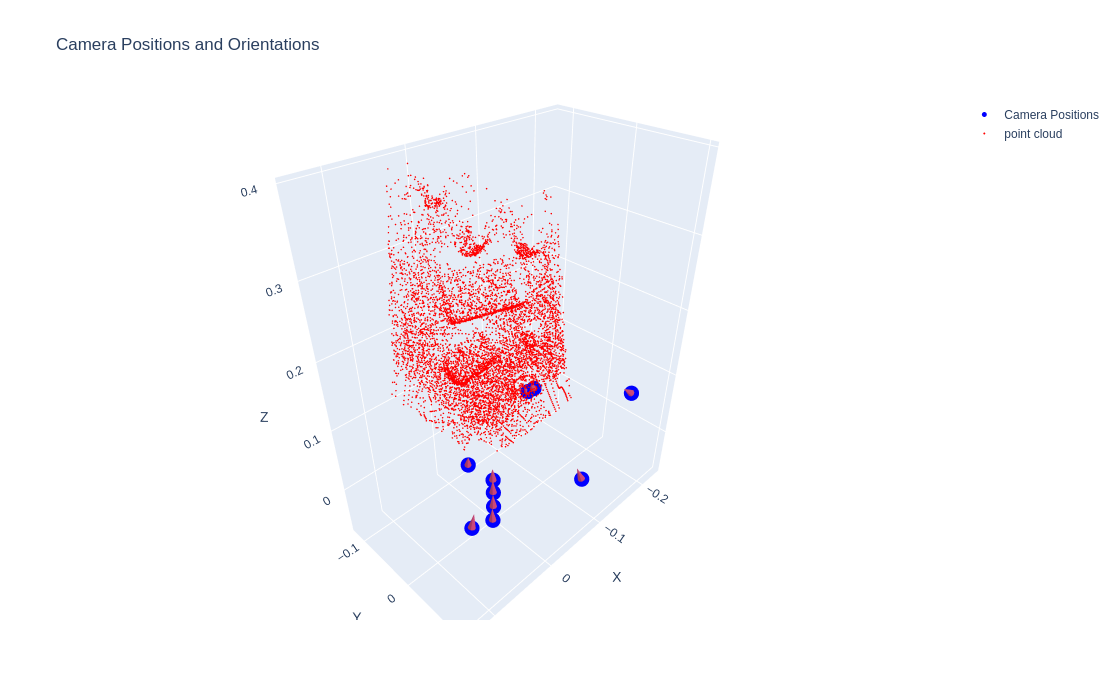

In [26]:
fig = go.Figure()

# Camera positions
fig.add_trace(go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                           mode='markers', marker=dict(size=5, color='blue'), name='Camera Positions'))

fig.add_trace(go.Scatter3d(x=pts_tor[::200, 0].detach().cpu(),  # X coordinates
    y=pts_tor[::200, 1].detach().cpu(),  # Y coordinates
    z=pts_tor[::200, 2].detach().cpu(),  # Z coordinates
                           mode='markers', marker=dict(size=0.5, color='red'),name="point cloud"))

# Directions
for position, direction in zip(positions, directions):
    fig.add_trace(go.Cone(x=[position[0]], y=[position[1]], z=[position[2]],
                          u=[direction[0]], v=[direction[1]], w=[direction[2]],
                          anchor="tail", showscale=False, sizeref=0.02))

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title="Camera Positions and Orientations")

fig.update_layout(width=1000, height=700)
fig.show()

In [8]:
eef_poses = [
    [3.008, -0.668, 0.549, -0.16574, -0.268, 0.5065], # right back 0
    [3.008, -0.5914, 0.633, -0.111, -0.2634, 0.485], # right back 1
    [-2.31092, -0.24056, -0.99504, -0.21117, -0.12188, 0.41125], #right back 2
    [-2.51890, -0.54126, -0.08807, -0.00074, -0.49342, 0.42817], # right back corner
    [-3.008, -0.668, -0.549, -0.16574, 0.268, 0.5065], # left back 0
    [-3.008, -0.5914, -0.633, -0.111, 0.2634, 0.485], # left back 1
    [-3.008, -0.5914, -0.633, -0.061, 0.2634, 0.485], # left back 1 x + 5cm
    [-3.008, -0.5914, -0.633, -0.011, 0.2634, 0.485], # left back 1 x + 10cm
    [2.31092, -0.24056, 0.99504, -0.21117, 0.12188, 0.41125], # left back 2
    [2.39645, -0.54843, 0.08445, -0.00101, 0.49278, 0.42958], # left back corner
]

In [9]:
scale_factor=(0.05)/(0.5*(torch.norm(positions[6]-positions[5])+torch.norm(positions[6]-positions[7])))

In [10]:
scale_factor

tensor(2.7955)

In [13]:
eef_poses_6d=torch.tensor(eef_poses)
eef_mats=pose_to_transform(eef_poses_6d)
poses_scaled=poses.clone()
poses_scaled[:,:3,3]=poses_scaled[:,:3,3]*scale_factor
# world-space coordinates to camera pose
poses_scaled_np=np.array(poses_scaled.cpu().detach())
# robot base to manipulator end-effector pose
eef_mats_np=np.array(eef_mats.cpu().detach())
R_base2world, t_base2world, R_gripper2cam, t_gripper2cam =cv2.calibrateRobotWorldHandEye(poses_scaled_np[:,:3,:3], 
                                                                                         poses_scaled_np[:,:3,3],
                                                                                         eef_mats_np[:,:3,:3],
                                                                                         eef_mats_np[:,:3,3],
                                                                                        method=cv2.CALIB_ROBOT_WORLD_HAND_EYE_SHAH)

In [41]:
poses_scaled[:,:3,3]

tensor([[-0.3926, -0.1749,  0.1171],
        [-0.3858, -0.2032,  0.0900],
        [-0.2374,  0.2334, -0.0036],
        [-0.5857,  0.1769,  0.1730],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0135,  0.0150, -0.0445],
        [ 0.0353,  0.0388, -0.0837],
        [ 0.0598,  0.0611, -0.1202],
        [-0.0150, -0.1632, -0.0425],
        [ 0.1966,  0.1060, -0.0124]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [15]:
t_base2world

array([[-0.18943137],
       [ 0.26120791],
       [ 1.55055502]])

In [16]:
t_base2world

array([[-0.18943137],
       [ 0.26120791],
       [ 1.55055502]])

In [17]:
t_base2world

array([[-0.18943137],
       [ 0.26120791],
       [ 1.55055502]])

In [18]:
print(residual_error(R_base2world, poses_scaled_np[:,:3,:3], eef_mats_np[:,:3,:3], R_gripper2cam))

0.07234596252212905


In [19]:
np.linalg.norm(poses_scaled_np[:,:3,:3]@R_base2world-R_gripper2cam@eef_mats_np[:,:3,:3])

0.38730321996598027

In [20]:
t_gripper2cam

array([[ 0.01203871],
       [-0.13354158],
       [ 1.11211888]])

In [21]:
R_base2world_tor=torch.tensor(R_base2world)

In [78]:
#tr_pts=(torch.linalg.inv(R_base2world_tor).float()@(pts_tor[::200].detach().cpu()).T).T

tr_pts=pts_tor[::200].detach().cpu()@torch.linalg.inv(R_base2world_tor).float()

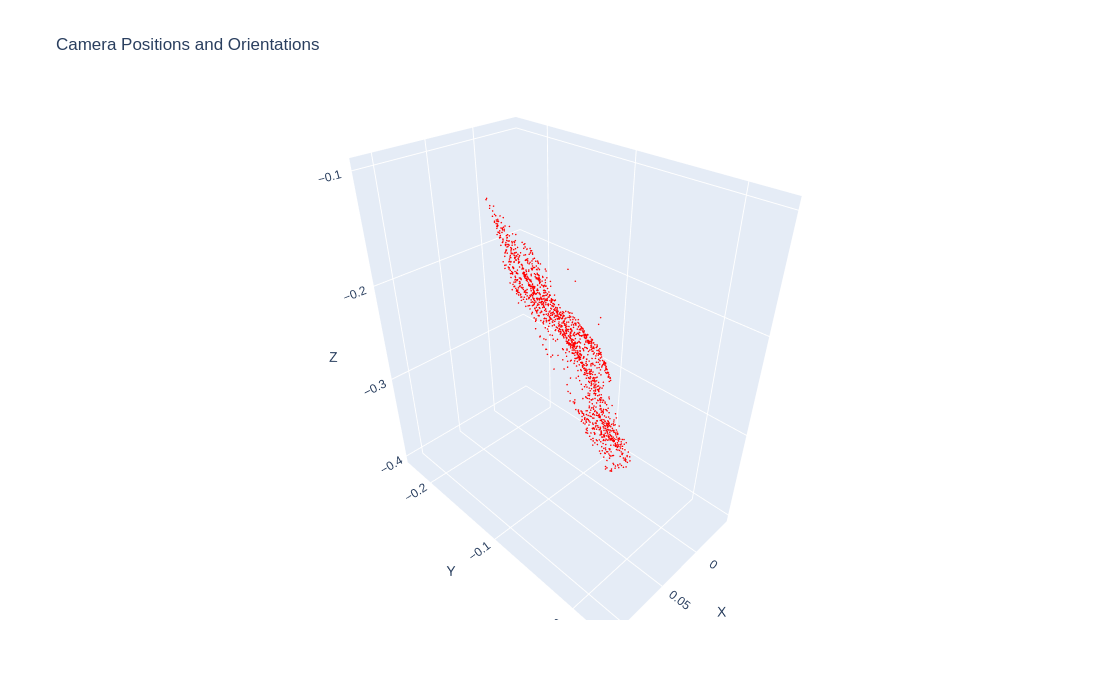

In [79]:
fig = go.Figure()

# Camera positions
fig.add_trace(go.Scatter3d(x=tr_pts[::5, 0].detach().cpu(),  # X coordinates
    y=tr_pts[::5, 1].detach().cpu(),  # Y coordinates
    z=tr_pts[::5, 2].detach().cpu(),  # Z coordinates
                           mode='markers', marker=dict(size=0.5, color='red'),name="point cloud"))


fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title="Camera Positions and Orientations")

fig.update_layout(width=1000, height=700)
fig.show()

In [74]:
#cam_pts=(torch.linalg.inv(R_base2world_tor).float()@(torch.tensor(poses_scaled_np[:,:3,:3]).float()).T).T

/tmp/ipykernel_13498/2207223853.py:1: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/aten/src/ATen/native/TensorShape.cpp:3637.)



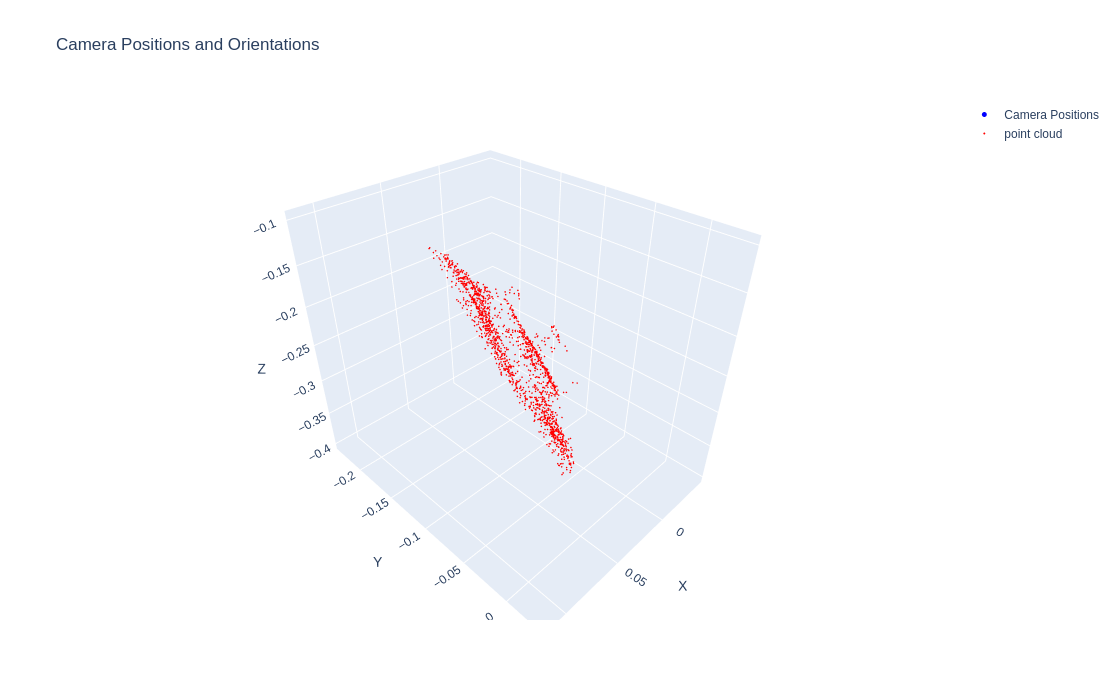

In [75]:
fig = go.Figure()

# Camera positions
fig.add_trace(go.Scatter3d(x=cam_pts[:, 0], y=cam_pts[:, 1], z=cam_pts[:, 2],
                           mode='markers', marker=dict(size=5, color='blue'), name='Camera Positions'))

fig.add_trace(go.Scatter3d(x=tr_pts[::5, 0].detach().cpu(),  # X coordinates
    y=tr_pts[::5, 1].detach().cpu(),  # Y coordinates
    z=tr_pts[::5, 2].detach().cpu(),  # Z coordinates
                           mode='markers', marker=dict(size=0.5, color='red'),name="point cloud"))


fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title="Camera Positions and Orientations")

fig.update_layout(width=1000, height=700)
fig.show()

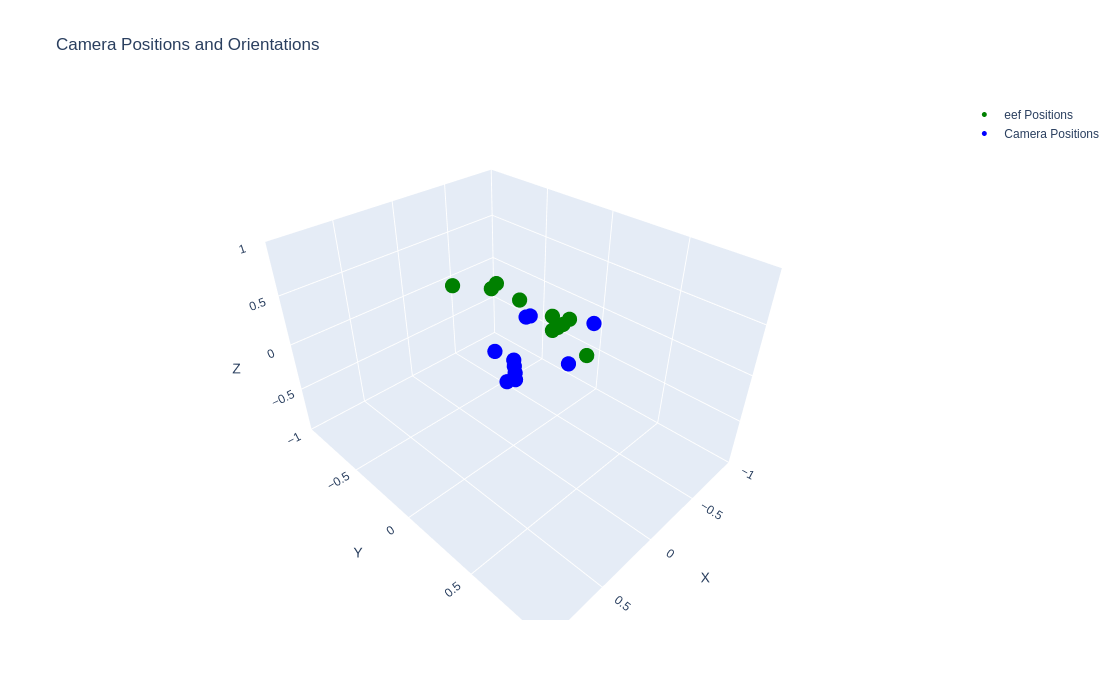

In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=eef_mats_np[:, 0,3], y=eef_mats_np[:, 1,3], z=eef_mats_np[:, 2,3],
                           mode='markers', marker=dict(size=5, color='green'), name='eef Positions'))


# Camera positions
fig.add_trace(go.Scatter3d(x=poses_scaled[:, 0, 3].cpu().detach(), y=poses_scaled[:, 1, 3].cpu().detach(), z=poses_scaled[:, 2, 3].cpu().detach(),
                           mode='markers', marker=dict(size=5, color='blue'), name='Camera Positions'))

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title="Camera Positions and Orientations")

fig.update_layout(scene=dict(
                    xaxis=dict(range=[-1., 1.]),
                    yaxis=dict(range=[-1., 1.]),
                    zaxis=dict(range=[-1., 1.])
))

fig.update_layout(width=1000, height=700)
fig.show()

In [80]:
positions_cam=poses_scaled[:,:3,3].cpu().detach()
#cam_pts=(torch.linalg.inv(R_base2world_tor).float()@(positions_cam.T)).T
cam_pts=positions_cam@torch.linalg.inv(R_base2world_tor).float()

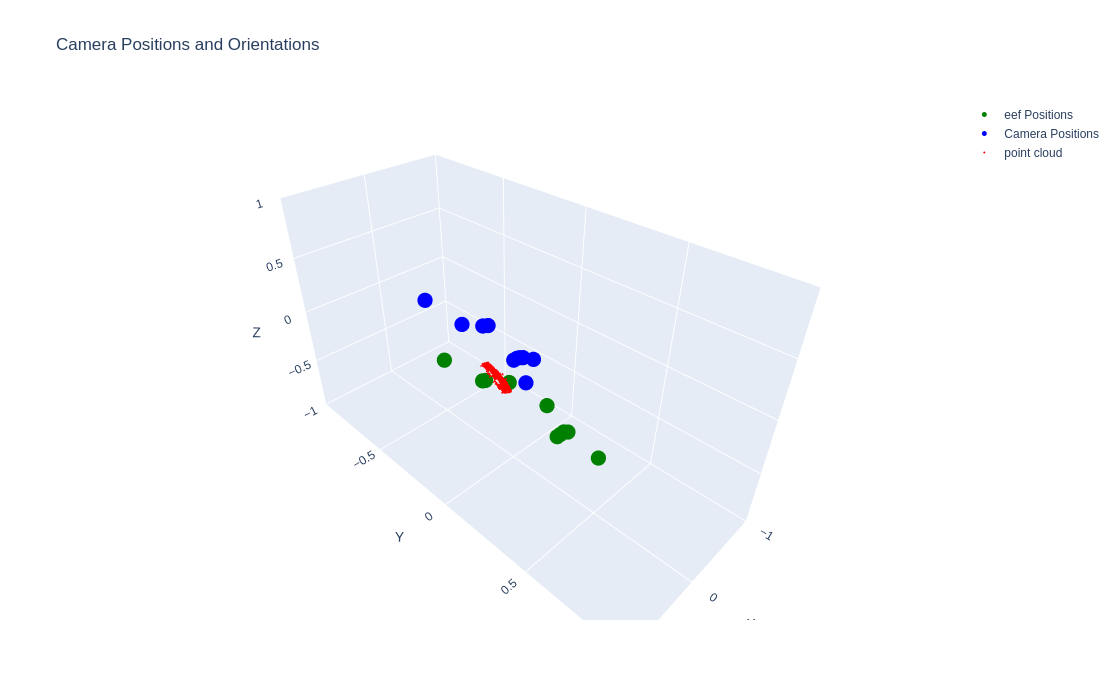

In [81]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=eef_mats_np[:, 0,3], y=eef_mats_np[:, 1,3], z=-eef_mats_np[:, 2,3],
                           mode='markers', marker=dict(size=5, color='green'), name='eef Positions'))

# Camera positions
fig.add_trace(go.Scatter3d(x=cam_pts[:, 0], y=cam_pts[:, 1], z=cam_pts[:, 2],
                           mode='markers', marker=dict(size=5, color='blue'), name='Camera Positions'))

fig.add_trace(go.Scatter3d(x=tr_pts[::5, 0].detach().cpu(),  # X coordinates
    y=tr_pts[::5, 1].detach().cpu(),  # Y coordinates
    z=tr_pts[::5, 2].detach().cpu(),  # Z coordinates
                           mode='markers', marker=dict(size=0.5, color='red'),name="point cloud"))

fig.update_layout(scene=dict(
                    xaxis=dict(range=[-1., 1.]),
                    yaxis=dict(range=[-1., 1.]),
                    zaxis=dict(range=[-1., 1.])
))

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title="Camera Positions and Orientations")

fig.update_layout(width=1000, height=700)
fig.show()